## Download VQVAE from DALLE
| testing usage
```python
enc = encoder
dec = decoder
```

In [1]:
import io
import os, sys
import requests
import pickle

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
from dall_e import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

In [2]:
device = torch.device('cuda:0')

In [3]:
from vqgan_jax.modeling_flax_vqgan import VQModel
# from transformers import VQGanForPreTraining
# from transformers import VQGanProcessor

# Load the pre-trained VQGAN model and its processor
checkpoint = "dalle-mini/vqgan_imagenet_f16_16384"
model = VQModel.from_pretrained(checkpoint)
# processor = VQGanProcessor.from_pretrained(checkpoint)


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
# target_image_size = 256

# def download_image(url):
#     resp = requests.get(url)
#     resp.raise_for_status()
#     return PIL.Image.open(io.BytesIO(resp.content))

# def preprocess(img):
#     s = min(img.size)
    
#     if s < target_image_size:
#         raise ValueError(f'min dim for image {s} < {target_image_size}')
        
#     r = target_image_size / s
#     s = (round(r * img.size[1]), round(r * img.size[0]))
#     img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
#     img = TF.center_crop(img, output_size=2 * [target_image_size])
#     img = torch.unsqueeze(T.ToTensor()(img), 0)
#     return map_pixels(img)

In [4]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = np.clip(x, -1., 1.)
  x = (x + 1.)/2.
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1)

In [ ]:
# enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", device)
# dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", device)

In [ ]:
# x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
# display_markdown('Original image:')
# display(T.ToPILImage(mode='RGB')(x[0]))

In [5]:
import numpy as np
from torchvision.transforms import InterpolationMode
def resize_image(image, size=256):
    s = min(image.size)
    r = size / s
    s = (round(r * image.size[1]), round(r * image.size[0]))
    image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
    image = TF.center_crop(image, output_size = 2 * [size])
    image = np.expand_dims(np.array(image), axis=0)
    return image

In [6]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=256
image = download_image(url)
image = resize_image(image)
image.shape

(1, 256, 256, 3)

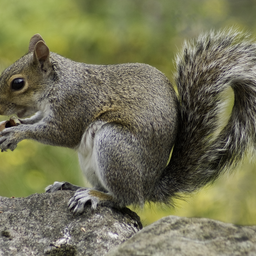

In [7]:
display(T.ToPILImage(mode='RGB')(image[0]))

In [8]:
_, id = model.encode(image)

In [9]:
enc = model.encode

In [10]:
# imageCodebook_len = enc.vocab_size
imageCodebook_len = 16384

In [11]:
def process_image_with_encoder(image):
    z = enc(image)
    # z = torch.argmax(z, axis=1)
    z_ = F.one_hot(z, num_classes=imageCodebook_len).permute(0, 3, 1, 2).float()
    return z_

## Text LLM

In [12]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
llm = "gpt2-xl"
gpt2_model = GPT2LMHeadModel.from_pretrained(llm)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(llm)

gpt2_embeddings = gpt2_model.transformer.wte.weight
# embedding_matrix = model.transformer.wte.weight
gpt2Codebook_len = gpt2_model.config.n_embd
gpt2Vocab_len = len(gpt2_embeddings)
gpt2_model.to(device)
gpt2_model.eval()

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [13]:
print("gpt2 codebook length:", gpt2Codebook_len)
print("gpt2 vocabulary length:", gpt2Vocab_len)
print("gpt2 embedding shape:", gpt2_embeddings.shape)

gpt2 codebook length: 1600
gpt2 vocabulary length: 50257
gpt2 embedding shape: torch.Size([50257, 1600])


In [14]:
def forward_gpt2_with_embeddings(embeddings):
    """
    Forward pass through GPT-2 for sequential token prediction logits from embeddings.

    :param embeddings: Embeddings of the sequence, shape [batch_size, seq_len, embedding_dim].
    :return: Tensor of logits for token predictions, shape [batch_size, seq_len, vocab_size].
    """
    batch_size, seq_len, _ = embeddings.size()
    vocab_size = gpt2_model.config.vocab_size
    predicted_logits = torch.zeros((batch_size, seq_len, vocab_size), device=embeddings.device)
    
    gpt2_model.eval()

    embeddings = embeddings.detach()
    
    for i in range(seq_len):
        # Use embeddings up to the i-th position to predict the next token
        input_embeddings = embeddings[:, :i+1, :]

        # Forward pass through GPT-2
        with torch.no_grad():
            outputs = gpt2_model(inputs_embeds=input_embeddings)
        logits = outputs.logits

        # Get the logits for the next position (i+1)
        predicted_logits[:, i, :] = logits[:, -1, :]  # Last token in the sequence

    predicted_logits.requires_grad = True

    return predicted_logits


## Changing Image tokens to Text tokens

In [15]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [16]:
class TokenMapper(nn.Module):
    def __init__(self, input_dim, output_dim, device="cpu"):
        super().__init__()
        self.mapper = nn.Linear(input_dim, output_dim)
        self.mapper.to(device)

    def forward(self, one_hot_token):
        return self.mapper(one_hot_token)

In [17]:
# Create the mapper
# mapper maps a 8192 to a 768
mapper = TokenMapper(imageCodebook_len, gpt2Codebook_len, device=device)

## Generate Ground Truth

In [18]:
def find_closest_indices_cosine(mapped_feature_vector, batch_size=10):
    # mapped_fv_reshaped has shape (-1, 768)
    mapped_fv_reshaped = mapped_feature_vector.view(-1, mapped_feature_vector.shape[-1])
    
    closest_indices = []
    for i in range(0, mapped_fv_reshaped.size(0), batch_size):
        # Process in smaller batches
        batch_fv = mapped_fv_reshaped[i:i+batch_size]

        # Compute cosine similarity for the batch
        distances_batch = F.cosine_similarity(batch_fv.unsqueeze(1), gpt2_embeddings.unsqueeze(0), dim=2)

        # Find the index of the maximum similarity for each vector in the batch
        closest_indices_batch = torch.argmax(distances_batch, dim=1)
        closest_indices.append(closest_indices_batch)

    # Concatenate results from all batches
    closest_indices = torch.cat(closest_indices, dim=0)

    # Reshape to the original batch and sequence dimension
    closest_indices_reshaped = closest_indices.view(mapped_feature_vector.shape[0], mapped_feature_vector.shape[1]).to(device)
    
    return closest_indices_reshaped


In [19]:
def find_closest_gpt2_token(batch_feature_vectors):
    """
    Find the GPT-2 token whose embedding is closest to the given feature vector.

    :param feature_vector: The feature vector (from the mapper). Shape: (embedding_dim,)
    :param embedding_matrix: GPT-2's embedding matrix. Shape: (vocab_size, embedding_dim)
    :return: The ID of the closest token.
    """
    batch_size, seq_len, embedding_dim = batch_feature_vectors.shape
    closest_tokens = torch.zeros((batch_size, seq_len), dtype=torch.long)
    
    # Normalize the feature vector and the embedding matrix for cosine similarity
    embedding_matrix_norm = F.normalize(gpt2_embeddings, dim=1)

    for i in range(batch_size):
        for j in range(seq_len):
            # Normalize the feature vector
            feature_vector_norm = F.normalize(batch_feature_vectors[i, j].unsqueeze(0), dim=1)

            # Compute cosine similarity
            cosine_similarities = torch.matmul(feature_vector_norm, embedding_matrix_norm.T).squeeze(0)

            # Find the token with the highest similarity
            closest_token_id = torch.argmax(cosine_similarities).item()
            closest_tokens[i, j] = closest_token_id

    return closest_tokens


In [20]:
def generate_next_token_predictions(token_sequences):
    # Initialize container for predictions
    predictions = torch.zeros(token_sequences.size(), dtype=torch.long).to(device)

    # first value of predictions are all start tokens
    # predictions[:, 0] = next_token_id

    for i in range(token_sequences.size(1)):  # Iterate over sequence length (256)
        # Input tokens up to the current step
        input_tokens = token_sequences[:, :i+1]
        # input_tokens = predictions[:, :i+1]
        
        # Get model predictions
        with torch.no_grad():
            outputs = gpt2_model(input_ids=input_tokens)
            logits = outputs.logits

        # Get the predicted next token (at the current step)
        # next_token = torch.argmax(logits[:, -1, :], dim=-1)
        # predictions[:, i] = next_token

    return logits
    # return logits, predictions

In [21]:
def get_gpt2_ground_truth(mapped_feature_vector):
    
    # ground_truth = find_closest_indices_cosine(mapped_feature_vector)
    ground_truth = find_closest_gpt2_token(mapped_feature_vector)
    # ground_truth = generate_next_token_predictions(closest_indices)
    
    return ground_truth


## Get Image Dataset

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms, datasets

from torch.utils.data import DataLoader

In [23]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size; adjust as needed
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std) for each color channel
])

In [24]:
# Replace 'path/to/lsun' with the actual path to your LSUN dataset
dataset_path = './data'

lsun_dataset = datasets.LSUN(root=dataset_path, classes=['classroom_train', 'living_room_train', 'bedroom_train'], transform=transform)

In [25]:
batch_size = 20  # Adjust based on your memory availability and requirements
lsun_loader = DataLoader(lsun_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print('dataset size:',len(lsun_loader))

dataset size: 225848


In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

## REINFORCE Loss Function

In [27]:
def reinforce_loss(logits, targets, rewards, gamma=1.0):
    """
    Calculate the REINFORCE loss for sequence prediction.

    :param logits: Logits from the model, shape [batch_size, seq_len, vocab_size].
    :param targets: Ground truth sequence, shape [batch_size, seq_len].
    :param rewards: Reward for each step in the sequence, shape [batch_size, seq_len].
    :param gamma: Discount factor for future rewards.
    :return: The REINFORCE loss (to be maximized).
    """
    
    batch_size, seq_len, _ = logits.shape

    # return loss / seq_len
    log_probs = F.log_softmax(logits, dim=2)
    log_probs_targets = log_probs.gather(2, targets.unsqueeze(2)).squeeze(2)

    # Create a discount matrix
    discounts = gamma ** torch.arange(seq_len).float().unsqueeze(0).to(logits.device)
    discount_matrix = torch.tril(discounts.repeat(seq_len, 1).T).T


    # Calculate discounted rewards
    discounted_rewards = rewards.unsqueeze(1) * discount_matrix
    cumulative_rewards = discounted_rewards.sum(dim=2)
    
    # Calculate loss
    loss = -torch.sum(log_probs_targets * cumulative_rewards) / batch_size / seq_len


    return loss

## Train Model

In [28]:
# Hyper Parameters
learning_rate = 1e-4
epochs = 1
gamma = 0.95

In [29]:
experiment = "rl"
exp_type = "image_vqgan"
experiment_name = f"{exp_type}/{experiment}/model={llm}_lr={learning_rate}"

In [30]:
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter instance (logs will be saved in 'runs' folder)
writer = SummaryWriter(f'runs/{experiment_name}')

In [31]:
optimizer = optim.Adam(mapper.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
rl_criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [32]:
def CELoss_SG(mapped_feature_vector, targets, reduction='mean'):
    """
    Custom cross-entropy loss with straight-through estimator.
    :return: Loss value.
    """

    batch_size, seq_len, embedding_dim = mapped_feature_vector.shape
    
    # Closest tokens have shape [batch_size, seq_len]
    closest_tokens = get_gpt2_ground_truth(mapped_feature_vector)

    closest_embeddings = gpt2_embeddings[closest_tokens.view(-1)]
    closest_embeddings = closest_embeddings.reshape(batch_size, seq_len, embedding_dim)

    # STE_LOGITS have shape [batch_size, seq_len, embedding_dim]
    ste_logits = (closest_embeddings - mapped_feature_vector.detach()) + mapped_feature_vector

    predictions = forward_gpt2_with_embeddings(ste_logits)
    predictions = predictions.reshape(batch_size*seq_len, -1)
    
    # Calculate cross-entropy loss
    loss = F.cross_entropy(predictions, targets, reduction=reduction)

    return loss, predictions


In [33]:
def process_image_with_encoder_(image):
    _, z = enc(image)
    z = np.asarray(z)
    z = torch.from_numpy(z).to(device)
    z_ = F.one_hot(z.long(), num_classes=imageCodebook_len).float()
    return z_

In [ ]:
# def train_on_lsun(dataloader, epochs=2):
for epoch in range(epochs):
    for i, (images, _) in enumerate(lsun_loader):
        optimizer.zero_grad()

        # for vqgan
        images = images.permute(0, 2, 3, 1)
        
        # Process each image through DALL-E encoder to get image tokens
        one_hot_image_tokens = process_image_with_encoder_(images).to(device)

        # Flatten the tokens for processing with the mapper
        flattened_tokens = one_hot_image_tokens.reshape(one_hot_image_tokens.size(0), -1, imageCodebook_len)

        # Map tokens and get ground truth from GPT-2
        mapped_feature_vector = mapper(flattened_tokens)

        # Straight Through Gradient
        # mapped_feature_vector = mapped_feature_vector.detach()
        # mapped_feature_vector.requires_grad = True
        
        ground_truth_tokens = get_gpt2_ground_truth(mapped_feature_vector).to(device)

        # get distribution of tokens from 768 -> 50257
        # mapped_lm_head = gpt2_model.lm_head(mapped_feature_vector)
        # next_token_logits = generate_next_token_predictions(ground_truth_tokens)
        
        # Calculate loss
        # next_token_logits = next_token_logits.reshape(-1, gpt2Vocab_len)
        ground_truth_tokens = ground_truth_tokens.reshape(-1)
        # loss = criterion(next_token_logits, ground_truth_tokens)
        # loss = CELoss_SG(mapped_feature_vector, ground_truth_tokens)
        
        # RL Loss
        rl_loss, prediction_logits = CELoss_SG(mapped_feature_vector, ground_truth_tokens, reduction='none')
        prediction_logits = prediction_logits.reshape(batch_size, -1, gpt2Vocab_len)
        ground_truth_tokens = ground_truth_tokens.reshape(batch_size, -1)
        rl_loss = rl_loss.reshape(batch_size, -1)
        loss = reinforce_loss(prediction_logits, ground_truth_tokens, rl_loss, gamma=0.9)
            
        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Log the losses
        writer.add_scalar('Training Loss', loss.item(), epoch * len(lsun_loader) + i)
        
        if i % 100 == 0:  # Print loss every 10 batches
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}")

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs} completed.")


/tmp/ipykernel_657822/1179520842.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  z = torch.from_numpy(z).to(device)


Epoch 1, Batch 0, Loss: 149.98252868652344


In [ ]:
from pathlib import Path
Path(f"models/{exp_type}/{experiment}").mkdir(parents=True, exist_ok=True)
torch.save(mapper.state_dict(), f"models/{experiment_name}")